# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [131]:
METRICS_PATH <- "./metrics/"

In [132]:
# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# install.packages(c('reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'zoo'))

Then, the dependencies

In [133]:
# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(zoo) # moving averages        

Load the the Python `integration.py` script to use its variable in R

In [134]:
#use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))

Load the graph network as an adjancency matrix

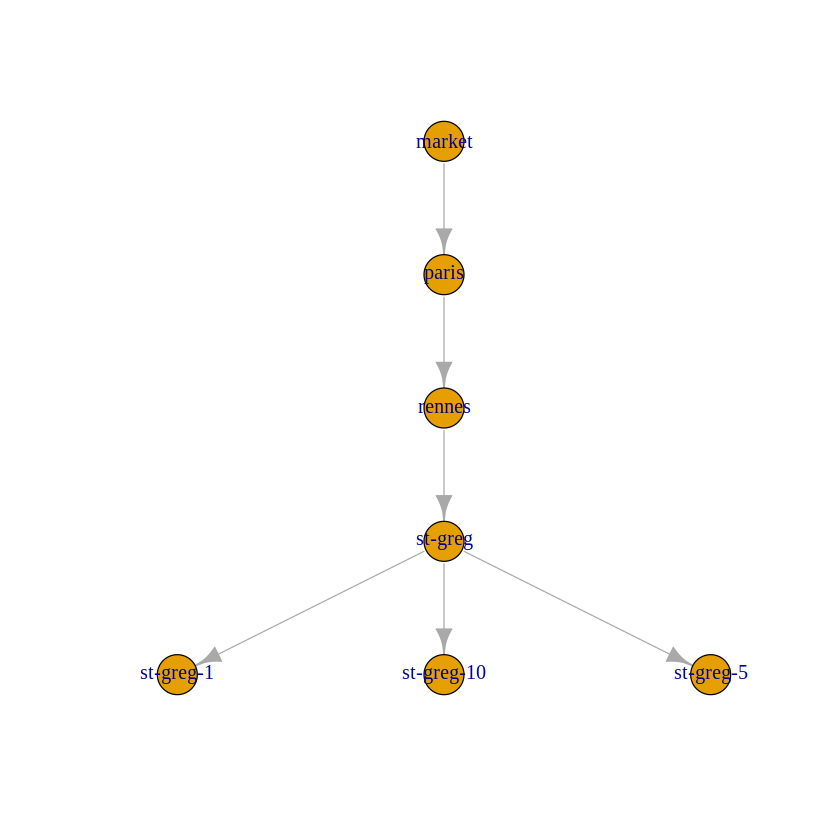

In [135]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout = layout_as_tree)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)

## Data preprocessing

In [136]:
names_raw <- read.csv2(file = paste(METRICS_PATH, "names.csv", sep = "/"), header = TRUE, sep = "\t")
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [137]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp_raw = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp_raw, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [138]:
mem <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  select(c(instance, value)) %>%
  mutate(dyn = formattable::percent(value / max(value, na.rm = TRUE))) %>%
  mutate(value = as.numeric(as.character(value)))

cpu <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  select(c(instance, value)) %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  group_by(instance) %>%
  mutate(value = as.numeric(as.character(value)))

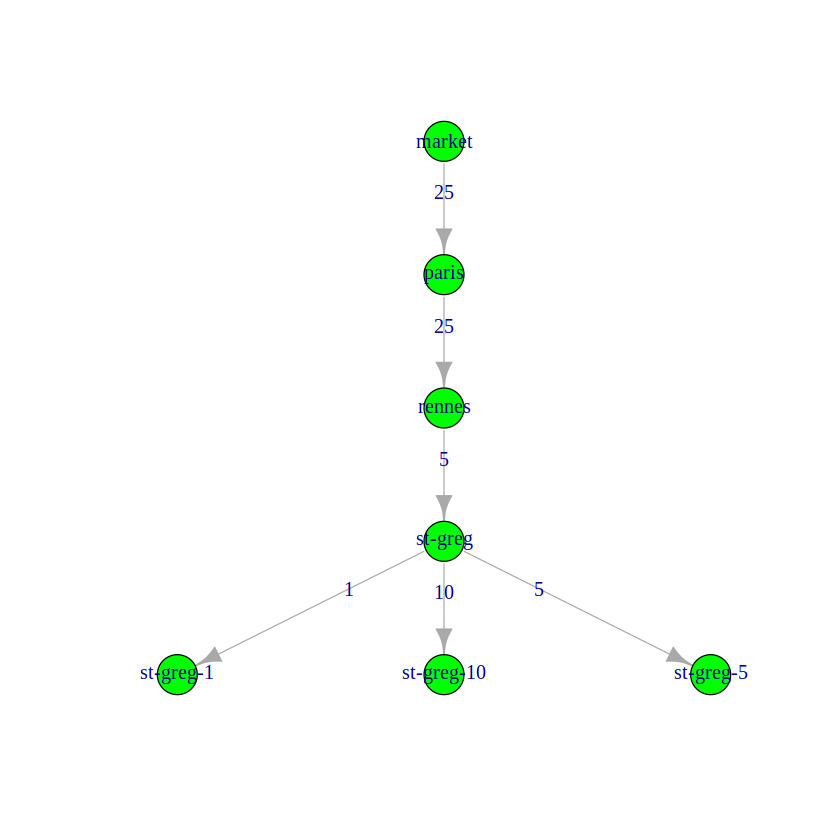

In [139]:
PercentageColourConnected <- function(x) {
  colorRampPalette(c("red", "green"))(2)[ifelse(is.na(x), 1, 2)]
}
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_connected)$color <- PercentageColourConnected(mem$value)
plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)

In [140]:
bids_raw <- read.csv2(file = paste(METRICS_PATH, "fog_node_bids.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare()

head(bids_raw)

,instance,name,bid_id,function_name,job,timestamp,value,timestamp_raw,n
,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>
1,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,echo-008-500-25-100,telegraf,2023-01-05 16:56:45,0.00083903,1672937805,0
2,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,echo-008-500-25-100,telegraf,2023-01-05 16:58:25,0.00083903,1672937905,0
3,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,echo-008-500-25-100,telegraf,2023-01-05 16:58:35,0.00083903,1672937915,0
4,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,echo-008-500-25-100,telegraf,2023-01-05 16:58:45,0.00083903,1672937925,0
5,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,echo-008-500-25-100,telegraf,2023-01-05 16:56:55,0.00083903,1672937815,0
6,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,echo-008-500-25-100,telegraf,2023-01-05 16:57:05,0.00083903,1672937825,0


instance,n
<chr>,<int>
market,2
paris,3
rennes,3
st-greg-5,2


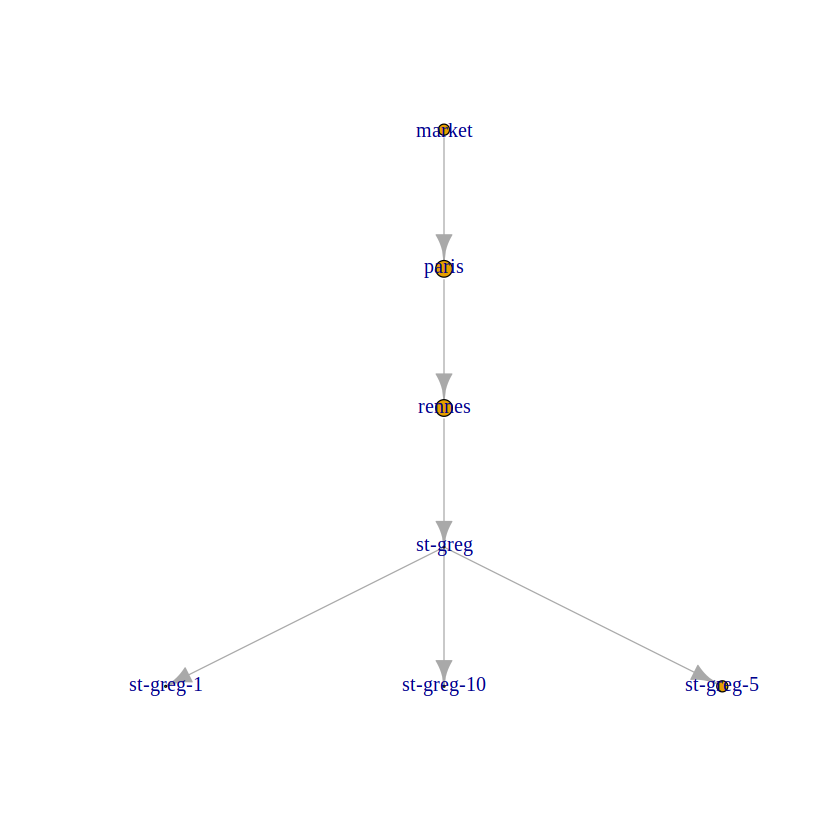

In [141]:
bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value))

bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
bids_won <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  group_by(instance) %>%
  summarise(n = n())

bids_won

# Add missing participants and put them at 0
bids_won <- bids_won %>%
  merge(bids_won_all_zero, all = TRUE) %>%
  group_by(instance) %>%
  summarise(across(everything(), sum)) %>%
  arrange()

net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_won)$size <- bids_won$n * 2
plot(net_won, layout = layout_as_tree)

Plot the free cpu

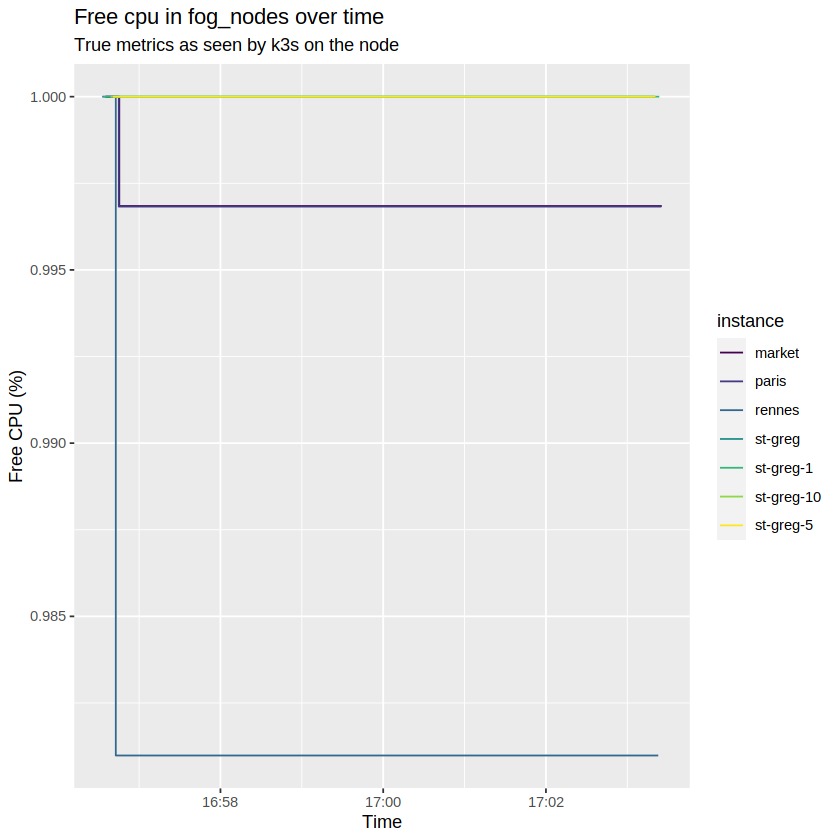

In [142]:
cpu_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
cpu_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

cpu_free %>%
ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free CPU (%)", title = "Free cpu in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Plot the free memory

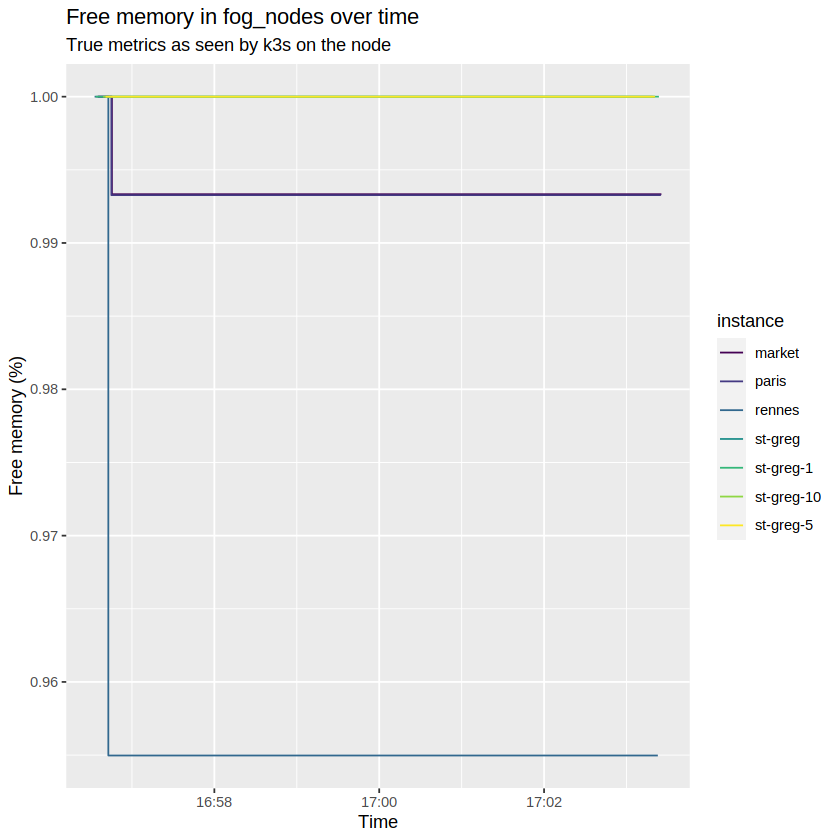

In [143]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

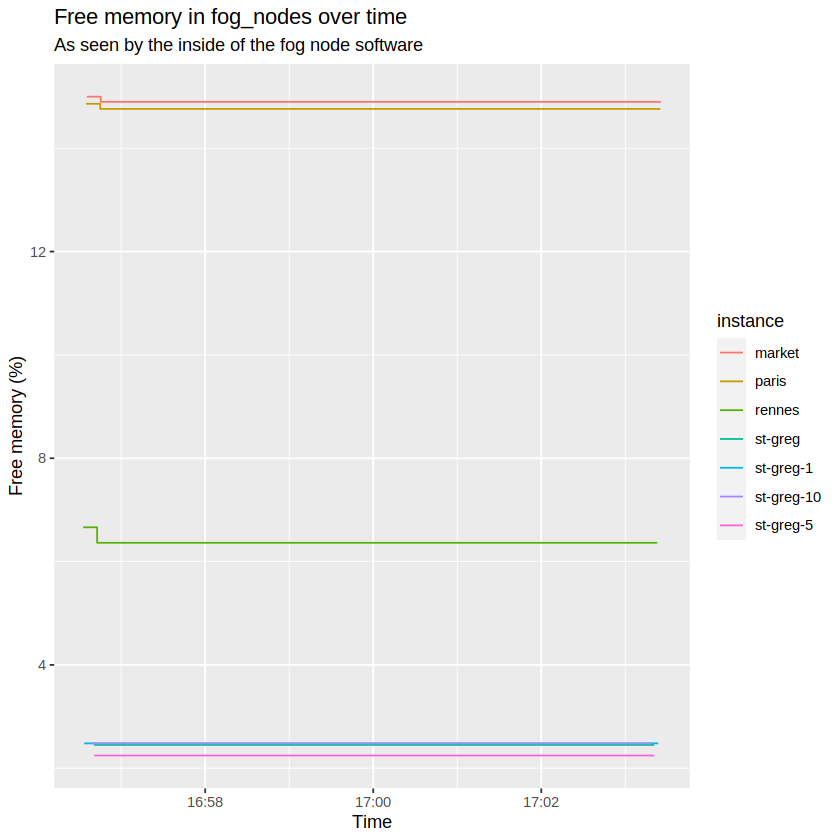

In [144]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "As seen by the inside of the fog node software")

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

In [145]:
latency <- read.csv2(file = paste(METRICS_PATH, "fog_node_neighbors_latency_rolling_avg.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  mutate(instance_to = as.character(names[instance_to]))

latency %>%
  group_by(instance, instance_to) %>%
  summarize(mean_ms = round(median(value*1000), 0))

# latency %>%
#   ggplot(aes(x = timestamp, y = value, color = instance_to)) +
# geom_smooth() +
#   labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
#   scale_y_continuous(trans='sqrt') + 
#   facet_grid(rows = vars(instance))+
#   scale_color_viridis(discrete = TRUE, option = "D") +
  # scale_fill_viridis(discrete = TRUE) 

# latency %>%
#   ggplot(aes(x = timestamp, y = value, color = instance_to)) +
# geom_point() +
#   labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
#   scale_color_viridis(discrete = TRUE, option = "D") +
#   scale_fill_viridis(discrete = TRUE) 

# latency %>% group_by(instance, instance_to) %>% mutate(median = median(value)) %>%
#   ggplot(aes(x = instance, y = median, color = instance_to)) +
#   geom_point() +
#   # scale_y_continuous(trans='sqrt') + 
#   labs(x = "Source", y = "Latency (s)", title = "Max latency from a node to its neighbors") +
#   # facet_grid(rows = vars(instance_to))+
#   scale_color_viridis(discrete = TRUE, option = "D") +
#   scale_fill_viridis(discrete = TRUE) 

`summarise()` has grouped output by 'instance'. You can override using the `.groups` argument.


instance,instance_to,mean_ms
<chr>,<chr>,<dbl>
market,paris,51
paris,market,50
paris,rennes,51
rennes,paris,51
rennes,st-greg,10
st-greg,rennes,10
st-greg,st-greg-1,2
st-greg,st-greg-10,20
st-greg,st-greg-5,11


Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”


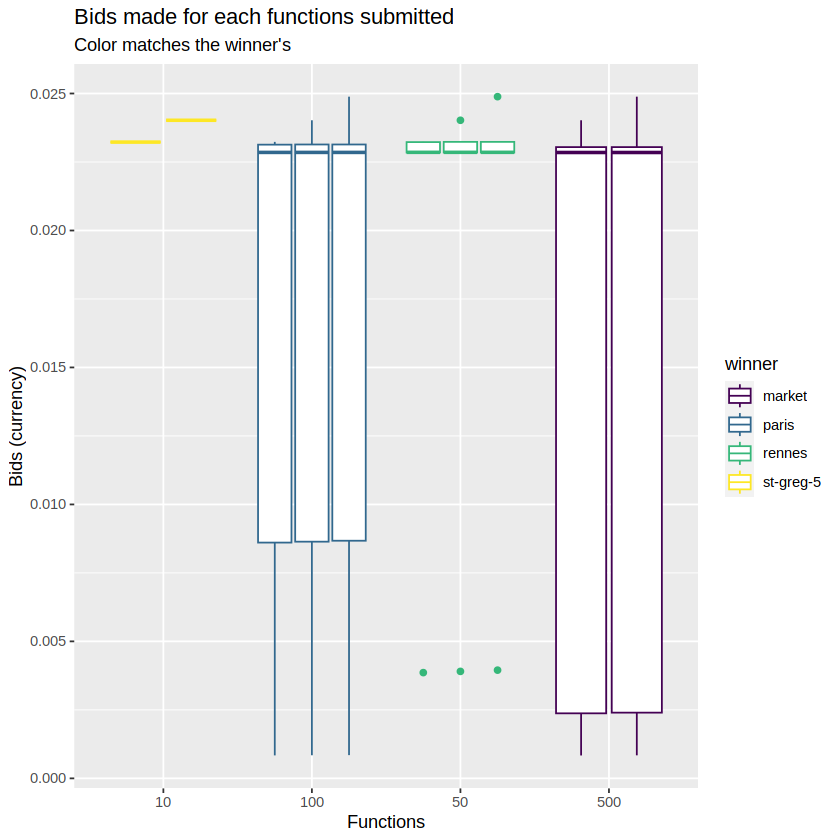

In [146]:
bids_won_function <- bids_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

# head(bids_won_function)

bids_function <- bids_raw %>%
  select(c(instance, function_name, value)) %>%
  distinct() %>%
  mutate(latency = stringr::str_match(function_name, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 4]) %>%
  inner_join(bids_won_function, by = c("function_name"))

# head(bids_function)

bids_function %>%
  ggplot(aes(x = latency, y = value.x, group = function_name, color = winner, label = instance.x)) +
  geom_boxplot() +
  # geom_point() +
  # geom_text(hjust = 0, vjust = 0) +
  labs(x = "Functions", y = "Bids (currency)", title = "Bids made for each functions submitted", subtitle = "Color matches the winner's")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

winner,function_name,value
<chr>,<chr>,<dbl>
paris,echo-001-100-25-100,0.0008384502
rennes,echo-002-50-25-100,0.0038597712
st-greg-5,echo-003-10-25-100,0.0232268191
market,echo-004-500-25-100,0.0008348542
paris,echo-005-100-25-100,0.0008426546
rennes,echo-006-50-25-100,0.0039043482


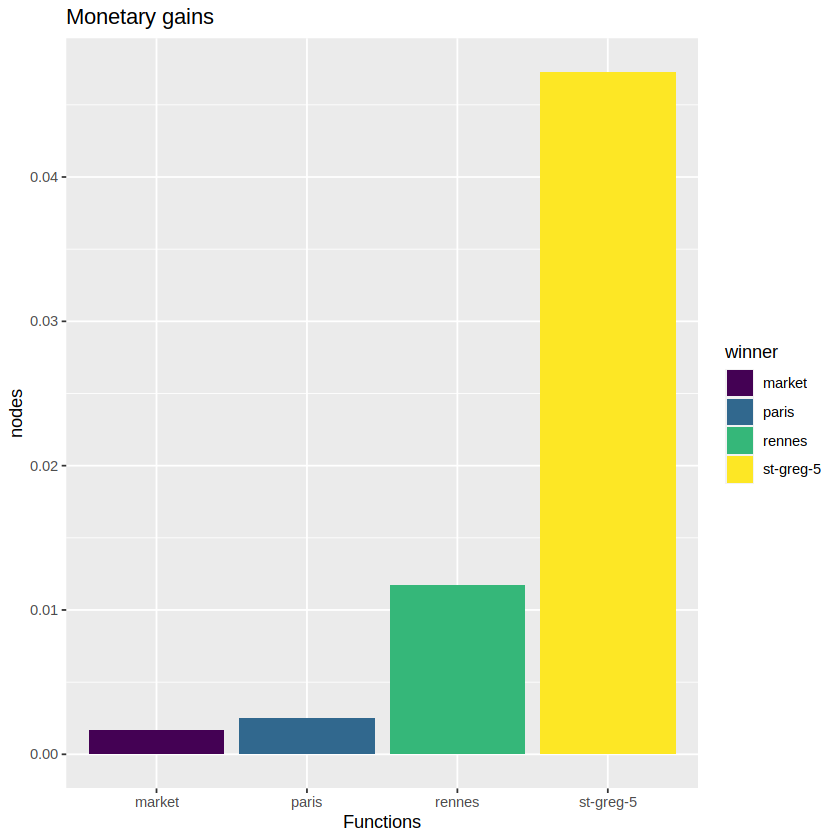

In [147]:
winner_gains <- bids_won_function %>%
  select(c(winner, function_name, value)) %>%
  distinct()
head(winner_gains)

winner_gains %>%
  ggplot(aes(x = winner, y = value, fill = winner)) +
  geom_col() +
  labs(x = "Functions", y = "nodes", title = "Monetary gains")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

,instance.x,function_name,value.x,latency,instance.y,name,bid_id,job,timestamp,value.y,timestamp_raw,n,winner
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>
1,market,echo-008-500-25-100,0.0008390300,500,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,telegraf,2023-01-05 16:56:45,0.0008390300,1672937805,0,market
2,market,echo-004-500-25-100,0.0008348542,500,market,fog_node_bids,b1f327e8-73dc-4347-b508-e6d6c9b8c281,telegraf,2023-01-05 16:57:55,0.0008348542,1672937875,0,market
3,paris,echo-008-500-25-100,0.0008469067,500,market,fog_node_bids,dcfa7f73-2180-4bc5-9796-7265c88a0476,telegraf,2023-01-05 16:56:45,0.0008390300,1672937805,0,market
4,paris,echo-009-100-25-100,0.0008469067,100,paris,fog_node_bids,429deb6c-c0cb-4b26-9f23-680c1033c4ff,telegraf,2023-01-05 17:02:45,0.0008469067,1672938165,0,paris
5,paris,echo-005-100-25-100,0.0008426546,100,paris,fog_node_bids,b2d20596-5102-4d78-bea1-5890a3f7bce2,telegraf,2023-01-05 17:02:55,0.0008426546,1672938175,0,paris
6,paris,echo-004-500-25-100,0.0008426546,500,market,fog_node_bids,b1f327e8-73dc-4347-b508-e6d6c9b8c281,telegraf,2023-01-05 16:57:55,0.0008348542,1672937875,0,market


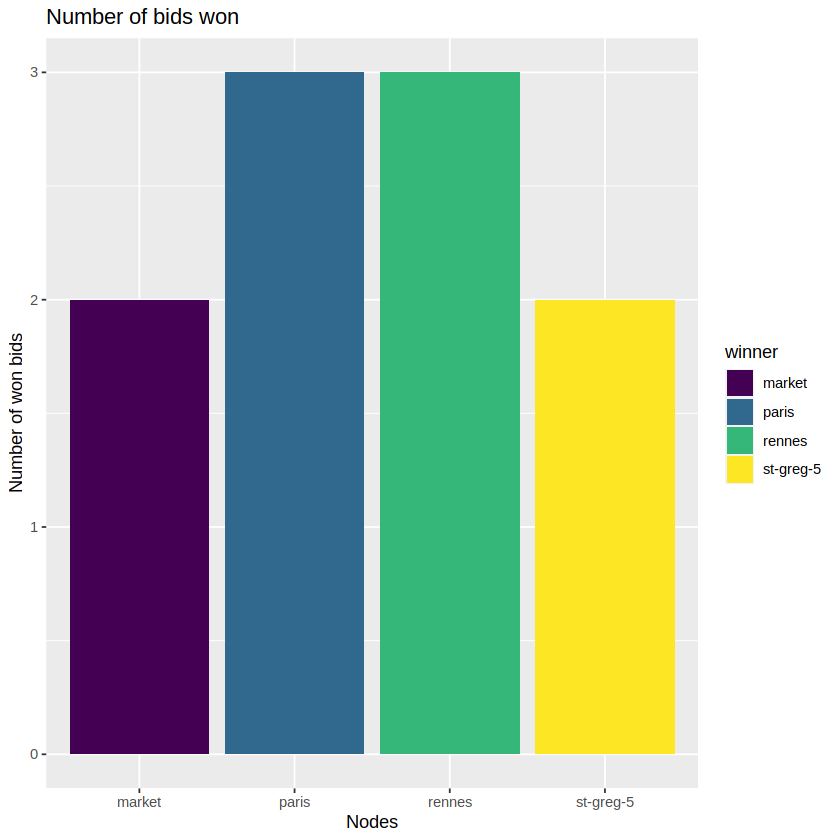

In [148]:
head(bids_function)

bids_function %>%
  select(winner, function_name) %>%
  distinct() %>%
  ggplot(aes(x = winner, fill = winner)) +
  geom_bar() +
  labs(x = "Nodes", y = "Number of won bids", title = "Number of bids won")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Warning message:
“Removed 6048 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4810 rows containing missing values (`geom_point()`).”


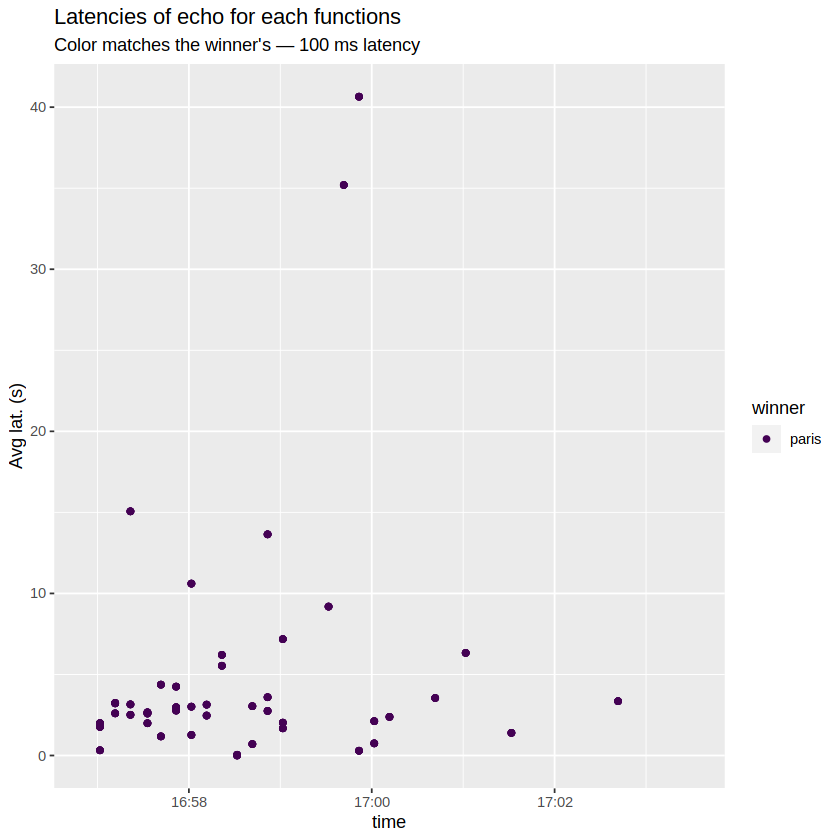

Warning message:
“Removed 656 rows containing missing values (`geom_point()`).”


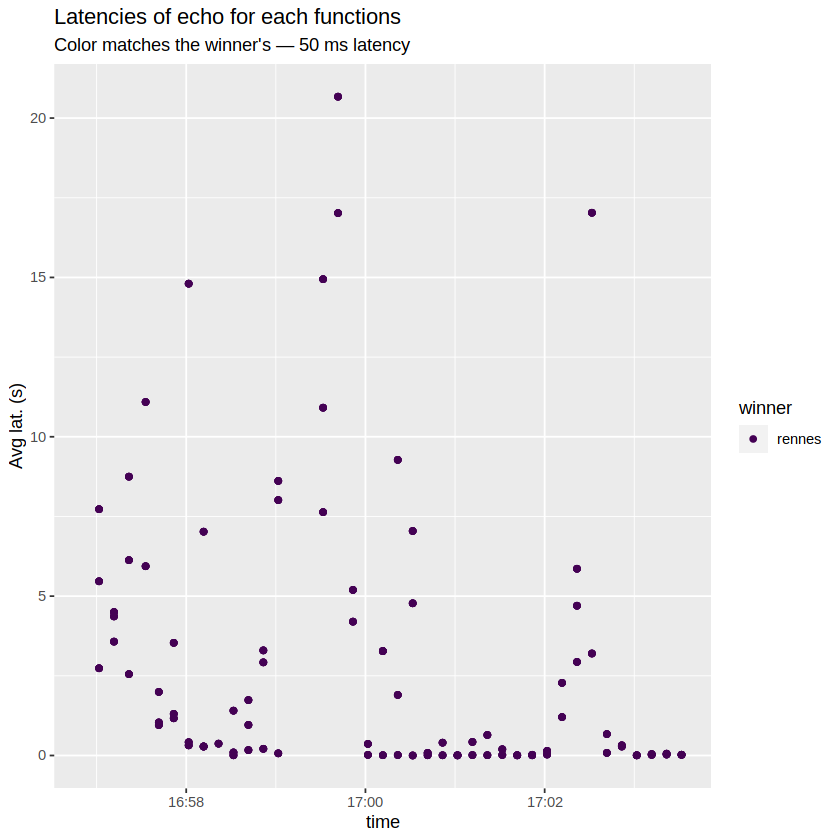

Warning message:
“Removed 4403 rows containing missing values (`geom_point()`).”


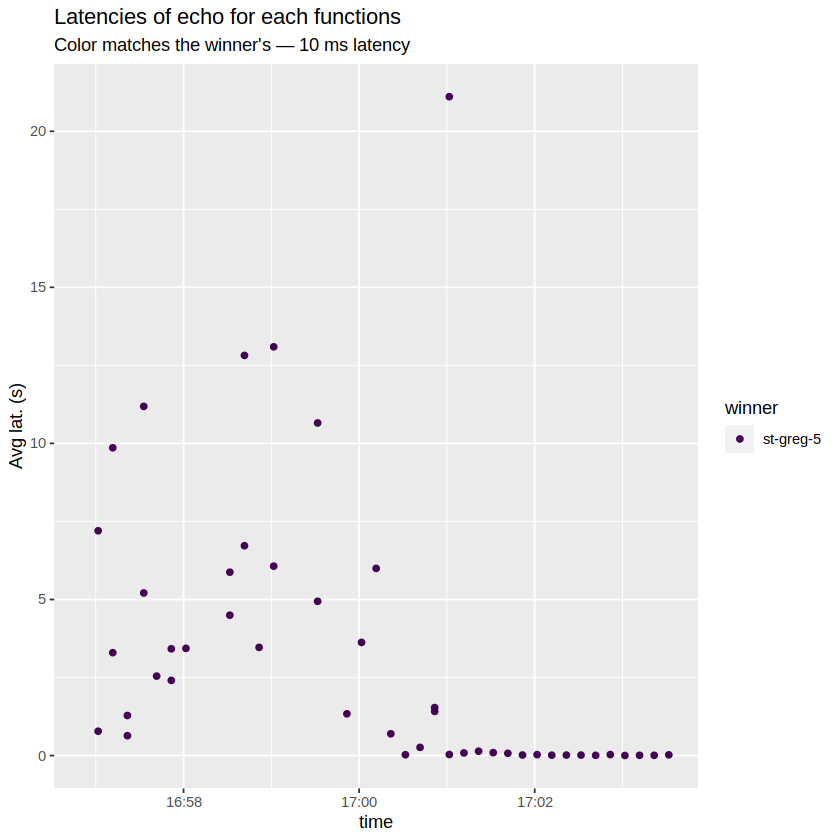

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


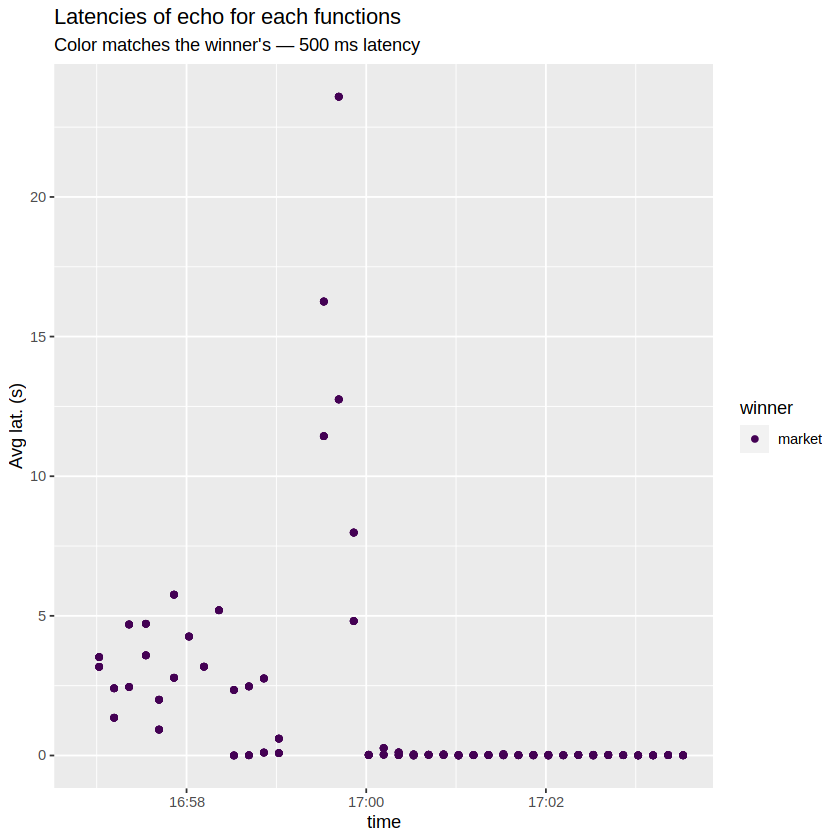

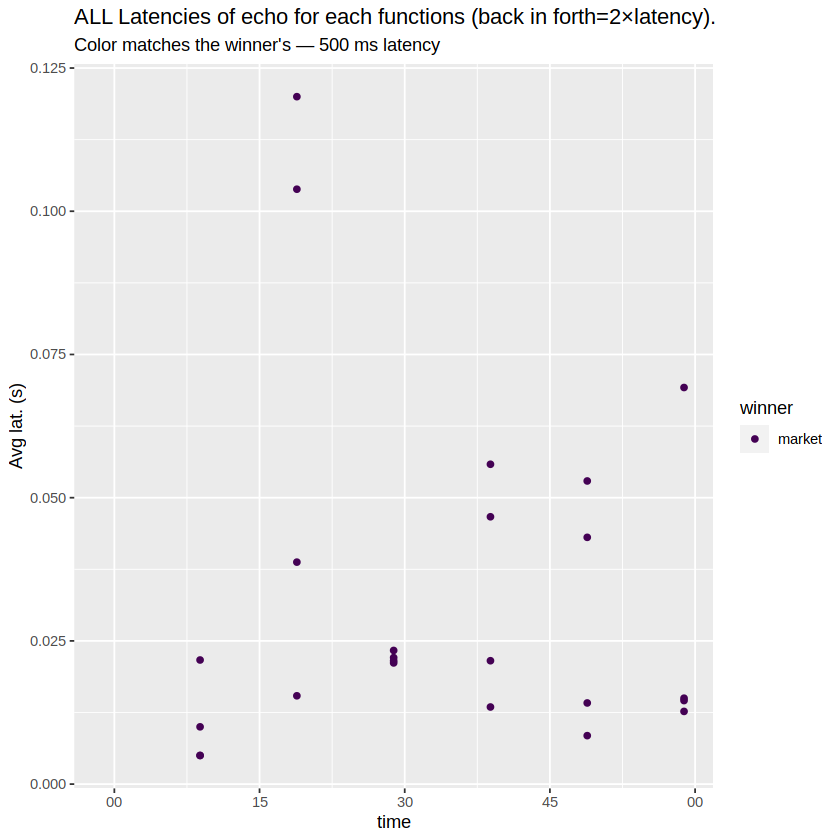

In [151]:
toto <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_sum.csv", header = TRUE, sep = "\t") %>%
  prepare()

titi <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_count.csv", header = TRUE, sep = "\t") %>%
  prepare()


latencies <- toto %>%
  mutate(latency = stringr::str_match(tag, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 4]) %>%
  select(latency) %>%
  distinct() %>%
  filter(!is.na(latency))

tutu <- toto %>%
  inner_join(titi,
             by = c("instance", "job", "timestamp", "timestamp_raw", "tag"),
  ) %>%
  group_by(tag) %>%
  mutate(new_x = value.x - dplyr::lag(x = value.x, n = 1,
                                      order_by = timestamp)) %>%
  mutate(new_y = value.y - dplyr::lag(x = value.y, n = 1,
                   
                   order_by = timestamp)) %>%
  mutate(new_avg = new_x / new_y) %>%
  mutate(function_name = tag) %>%
  mutate(latency = stringr::str_match(function_name, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 4]) %>%
  mutate(index = stringr::str_match(function_name, "(.+)-(.+)-([0-9]+)-([0-9]+)-([0-9]+)") %>% .[, 3]) %>%
  inner_join(bids_function %>% select(function_name, winner),
             by = c("function_name"))

# tata <- tutu %>%
#   group_by(winner, timestamp, latency) %>%
#   summarise(avg = mean(new_avg, na.rm = TRUE))

for (selected_latency in latencies$latency)
{
  # print(selected_latency)
  
  
  # print(
  #   tutu %>% filter(latency == selected_latency) %>%
  #     select(function_name) %>%
  #     distinct()
  # )
  
  
  # print(
  #   tutu %>% filter(latency == selected_latency) %>% 
  #     group_by(tag) %>%
  #     mutate(count = max(value.y)) %>%
  #     select(index, winner, count, latency) %>%
  #     distinct() %>%
  #     ggplot(
  #       aes(
  #         x = index,
  #         y = count,
  #         group = index,
  #         color = winner,
  #         label = latency
  #       )
  #     ) +
  #     geom_col() +
  #     labs(
  #       x = "Function id",
  #       y = "Number of echo requests",
  #       title = "Number of requests made to each functions (back in forth=2×latency)",
  #       subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
  #     ) +
  #     scale_color_viridis(discrete = TRUE, option = "D") +
  #     scale_fill_viridis(discrete = TRUE)
  # )
  
  # print(
  #   tutu %>% 
  #     filter(latency == selected_latency) %>%
  #     ggplot(
  #       aes(
  #         x = winner,
  #         y = new_avg,
  #         group = winner,
  #         color = winner,
  #         label = latency
  #       )
  #     ) +
  #     geom_violin() +
  #     labs(
  #       x = "time",
  #       y = "Avg lat. (s)",
  #       title = "Latencies of echo for each functions (back in forth=2×latency).",
  #       subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
  #     ) +
  #     scale_color_viridis(discrete = TRUE, option = "D") +
  #     scale_fill_viridis(discrete = TRUE)
  # )
  
  # print(
  #   tutu %>%
  #     filter(latency == selected_latency) %>%
  #     group_by(function_name) %>%
  #     ggplot(
  #       aes(
  #         x = timestamp,
  #         y = new_avg,
  #         group = index,
  #         color = winner,
  #         label = latency
  #       )
  #     ) +
  #     geom_point() +
  #     labs(
  #       x = "time",
  #       y = "Avg lat. (s)",
  #       title = "Latencies of echo for each functions",
  #       subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
  #     ) +
  #     scale_color_viridis(discrete = TRUE, option = "D") +
  #     scale_fill_viridis(discrete = TRUE)
  # )
    
    print(
    tutu %>%
      group_by(function_name) %>%
      filter(latency == selected_latency) %>%
      # mutate(rate = 1/(timestamp - lag(timestamp))) %>%
      ggplot(
        aes(
          x = timestamp,
          y = new_avg,
          group = index,
          color = winner,
          label = latency
        )
      ) +
      geom_point() +
      labs(
        x = "time",
        y = "Avg lat. (s)",
        title = "Latencies of echo for each functions",
        subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
      ) +
      scale_color_viridis(discrete = TRUE, option = "D") +
      scale_fill_viridis(discrete = TRUE)
  )
  
  # print(
  #   tata %>%
  #     filter(latency == selected_latency) %>%
  #     group_by(winner) %>%
  #     ggplot(
  #       aes(
  #         x = timestamp,
  #         y = avg,
  #         group = winner,
  #         color = winner,
  #         label = latency
  #       )
  #     ) +
  #     geom_point() +
  #     labs(
  #       x = "time",
  #       y = "Avg lat. (s)",
  #       title = "Latencies of echo for each functions (back in forth=2×latency).",
  #       subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
  #     ) +
  #     scale_color_viridis(discrete = TRUE, option = "D") +
  #     scale_fill_viridis(discrete = TRUE)
  # )
}
print(
  tata %>%
    group_by(winner) %>%
    ggplot(
      aes(
        x = timestamp,
        y = avg,
        group = winner,
        color = winner,
        # label = latency
      )
    ) +
    geom_point() +
    labs(
      x = "time",
      y = "Avg lat. (s)",
      title = "ALL Latencies of echo for each functions (back in forth=2×latency).",
      subtitle = paste("Color matches the winner's —", selected_latency, "ms latency")
    ) +
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)